In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from tqdm import tqdm_notebook
from itertools import product, combinations
import lightgbm as lgb
import gc
%matplotlib inline

In [2]:
datadir = '../data/raw'
item_categories = pd.read_csv(os.path.join(datadir, 'item_categories.csv'))
item = pd.read_csv(os.path.join(datadir, 'items.csv'))
train = pd.read_csv(os.path.join(datadir, 'sales_train_v2.csv'))
shops = pd.read_csv(os.path.join(datadir, 'shops.csv'))
test = pd.read_csv(os.path.join(datadir, 'test.csv'))

In [19]:
all_data = pd.read_csv('../data/processed/all_data.csv')
all_data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [4]:
file = open('../data/processed/lgb_model','rb')
lgb_model = pickle.load(file)
file.close()

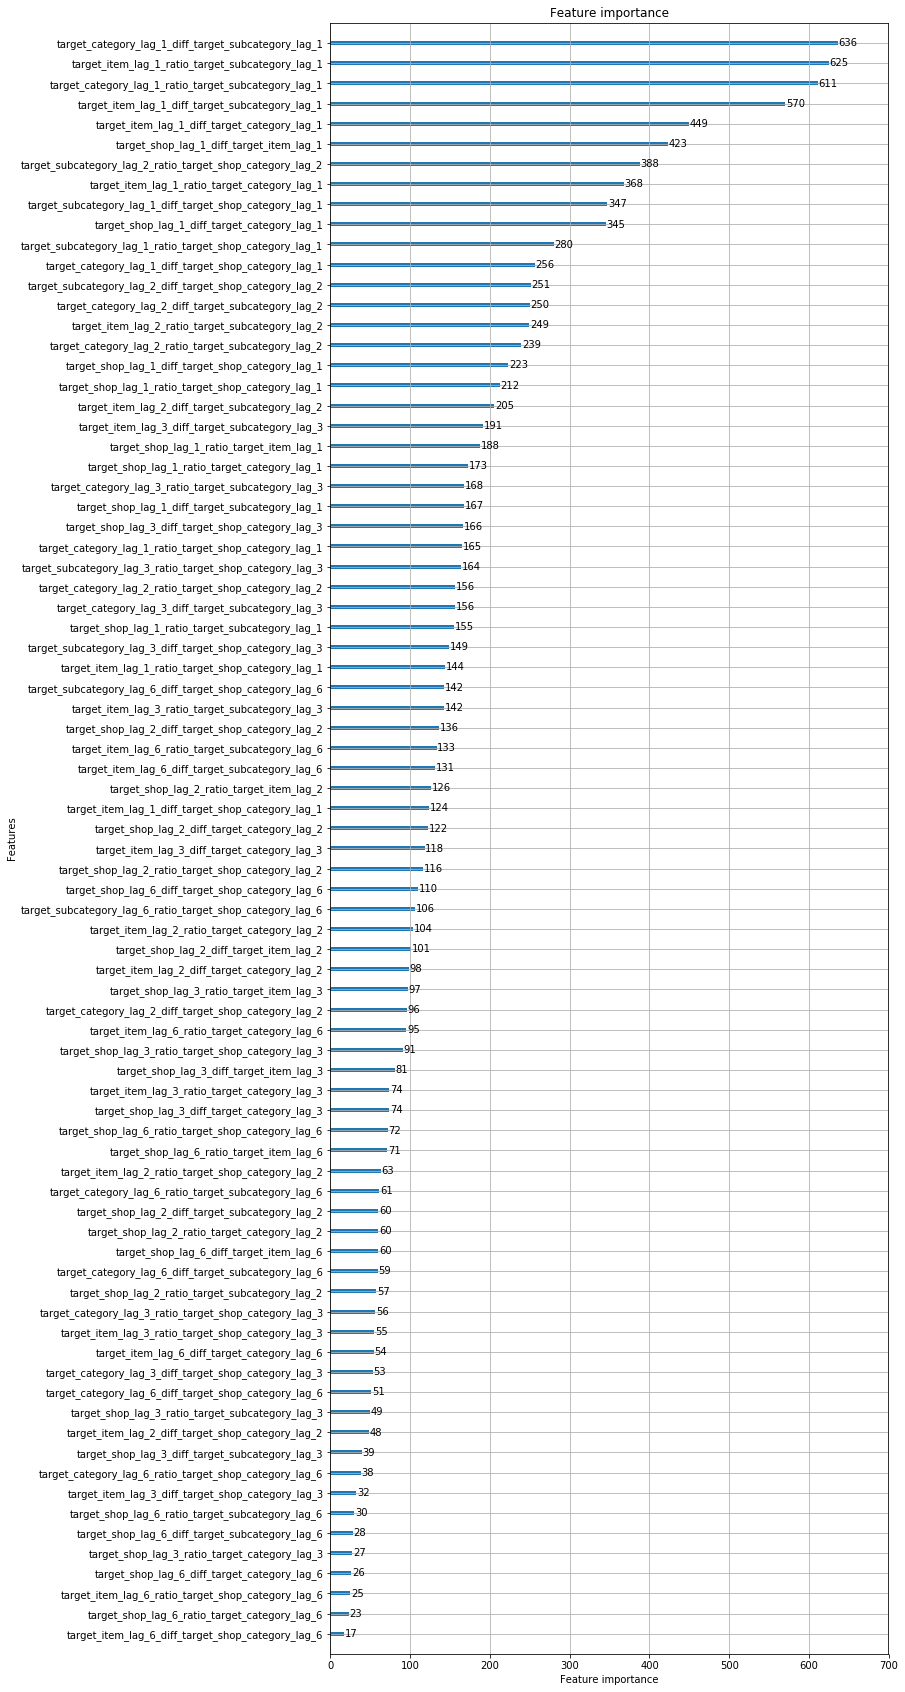

In [10]:
fig = plt.figure(figsize=(10, 14))
ax = lgb.plot_importance(lgb_model, figsize=(10, 30))
plt.show()

### Special features
special features like month number and number of days in the month can help with seasonality

In [11]:
def downcast_type(df):
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype == 'int64']
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    
    return df

In [20]:
# remove data prior to 2013
all_data = all_data[all_data['date_block_num'] >= 12]

In [21]:
all_data = downcast_type(all_data)
gc.collect()

14

In [22]:
all_data['month'] = all_data['date_block_num'] % 12

In [23]:
all_data.head(5)

,shop_id,item_id,date_block_num,city_code,item_category_id,item_category_name,category_type,category_subtype,target,target_shop,...,target_category_lag_3,target_subcategory_lag_3,target_shop_category_lag_3,target_lag_6,target_shop_lag_6,target_item_lag_6,target_category_lag_6,target_subcategory_lag_6,target_shop_category_lag_6,month
506809,55,492,12,28,76,Программы - Для дома и офиса (Цифра),15,33,20.0,4.349057,...,3.120930,5.750000,5.750000,20.0,3.541667,20.0,1.886792,9.666667,9.666667,0
506810,55,504,12,28,31,Игры PC - Цифра,8,63,7.0,4.349057,...,4.364042,3.733333,3.109375,3.0,3.541667,3.0,4.397213,3.540984,3.431035,0
506811,55,508,12,28,31,Игры PC - Цифра,8,63,3.0,4.349057,...,4.364042,3.733333,3.109375,2.0,3.541667,2.0,4.397213,3.540984,3.431035,0
506812,55,515,12,28,31,Игры PC - Цифра,8,63,6.0,4.349057,...,4.364042,3.733333,3.109375,3.0,3.541667,3.0,4.397213,3.540984,3.431035,0
506813,55,539,12,28,78,Программы - Обучающие (Цифра),15,47,2.0,4.349057,...,3.120930,1.571429,1.571429,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0


The most difficult targets are the predictions for new items. to help the model to focus on those, we compute the time that the item has been on the market. we also compute the mean target for new products in every shop or product category. 

In [24]:
first_item_sale = all_data.groupby(['item_id'])['date_block_num'].min()
all_data['elapsed_first_sale'] = all_data['date_block_num']-all_data['item_id'].map(first_item_sale)

In [27]:
last_item_sale = all_data[all_data['target'] > 0].groupby(['item_id'])['date_block_num'].max()
all_data['elapsed_last_sale'] = all_data['date_block_num']-all_data['item_id'].map(last_item_sale)
all_data['elapsed_last_sale'].clip(lower=0, inplace=True)

In [28]:
new_item_sales = all_data[all_data['elapsed_first_sale'] == 0]